In [13]:
#Importation des bibliothèques nécessaires
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [14]:
#Récupération des données historiques de Bitcoin
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data']['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


In [15]:
#Suppression des colonnes conversionType et conversionSymbol du DataFrame. parcequ'ils n'ont pas d'influence sur le resultat qu'on va prédire
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [16]:
hist.head(5)

high      low     open  volumefrom      volumeto    close
time                                                                    
2018-07-21  7453.07  7220.37  7333.93    40295.77  2.974404e+08  7405.40
2018-07-22  7569.28  7345.25  7405.40    47479.76  3.555653e+08  7398.64
2018-07-23  7798.59  7376.66  7398.64    96722.04  7.455333e+08  7718.00
2018-07-24  8485.71  7692.16  7718.00   143800.43  1.166561e+09  8395.82
2018-07-25  8481.11  8061.07  8395.81    89988.19  7.365307e+08  8170.23

In [17]:
#Définition d'une fonction pour séparer les données en ensembles d'entraînement et de test basée sur un pourcentage spécifié.
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [18]:
train, test = train_test_split(hist, test_size=0.2)

In [20]:
#Définition d'une fonction pour tracer des graphiques linéaires, utile pour la visualisation des séries temporelles.
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

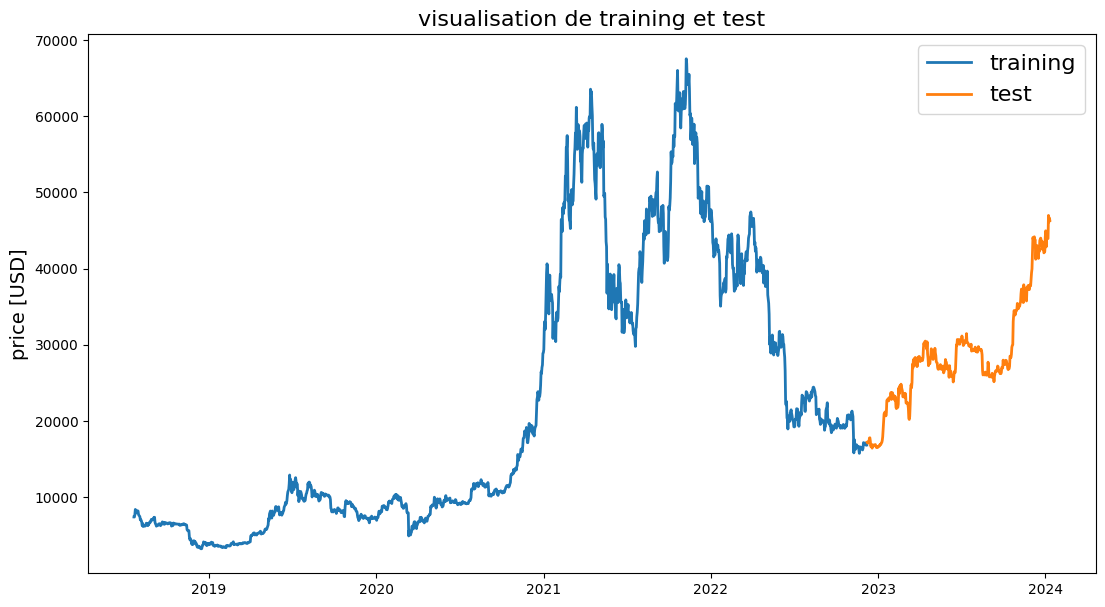

In [21]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='visualisation de training et test')

In [24]:
# Définition de fonctions pour normaliser les données soit par rapport à la première valeur (base zéro) soit en utilisant la normalisation min-max.
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [25]:
# Définition d'une fonction qui sert à extraire des fenetres de longueur 5 pour les utiliser comme entré dans le modele LSTM
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [32]:
#préparer les données pour le modèle LSTM, incluant la fenêtrisation des données.
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    print(X_test)
    y_train = train_data[target_col][window_len:].values
    print("-----------------------")
    print(y_train)
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test



In [33]:
# Définition d'une fonction pour construire un modèle LSTM (Long Short-Term Memory) avec Keras. Le modèle comprend des couches LSTM, Dropout, Dense, et Activation.
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [34]:
#Définition des hyperparamètres du modèle, tels que la taille de la fenêtre, le nombre de neurones LSTM, le nombre d'époques, la taille du lot.
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [35]:
#Préparation des données d'entrée et de sortie pour l'entraînement et le test du modèle LSTM.
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.89394816e-03  1.90680672e-02  2.30534183e-02 -1.48358482e-01
   -1.39458229e-01 -5.75698856e-03]
  [-3.78268998e-03  2.05784032e-02  1.71637115e-02 -6.44869460e-01
   -6.41637915e-01 -5.62114754e-03]
  [-1.56189983e-03  1.92482811e-02  1.73026841e-02 -5.45319086e-01
   -5.41167781e-01 -7.61580446e-03]
  [-2.74836521e-03  7.39294874e-03  1.52620436e-02 -1.07479476e-01
   -1.06841422e-01 -1.00777777e-03]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.66590721e-03  1.48207573e-03 -5.75698856e-03 -5.83004665e-01
   -5.83562243e-01  1.36627576e-04]
  [-3.44931516e-03  1.76841908e-04 -5.62114754e-03 -4.66112320e-01
   -4.66810056e-01 -1.86957905e-03]
  [-4.63353769e-03 -1.14566620e-02 -7.61580446e-03  4.80002508e-02
    3.79026422e-02  4.77671025e-03]
  [ 3.61265819e-02  1.10262686e-03 -1.00777777e-03  9.30202942e-01
    

In [36]:
#Construction et entraînement du modèle LSTM avec les données préparées.
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/20
50/50 [==============================] - 6s 29ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 2/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 7.5537e-04
Epoch 5/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 7.0095e-04
Epoch 6/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 7.4263e-04
Epoch 7/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 9.9221e-04
Epoch 8/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 8.1525e-04
Epoch 9/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 6.8501e-04
Epoch 10/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 

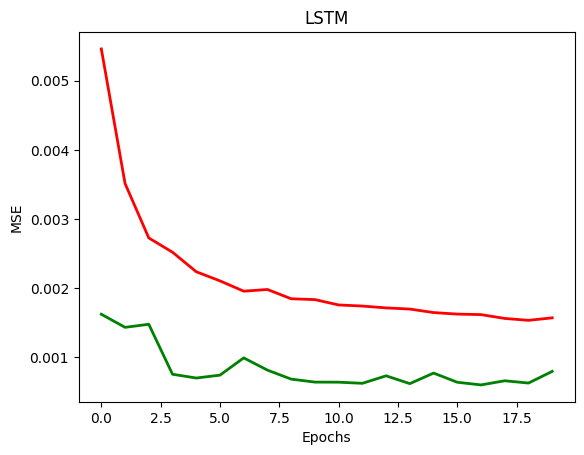

In [38]:
#Tracé des courbes de perte d'entraînement et de validation pour évaluer les performances du modèle au fil des époques.
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [39]:
# Calcul de l'erreur absolue moyenne entre les prédictions et les valeurs réelles.
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 1s 4ms/step


0.019365051392856224

In [40]:
#Calcul de l'erreur quadratique moyenne pour les prédictions.
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

0.0007970108069193775

In [41]:
# Calcul du R², une mesure statistique de la qualité de la prédiction.
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7418649471211849

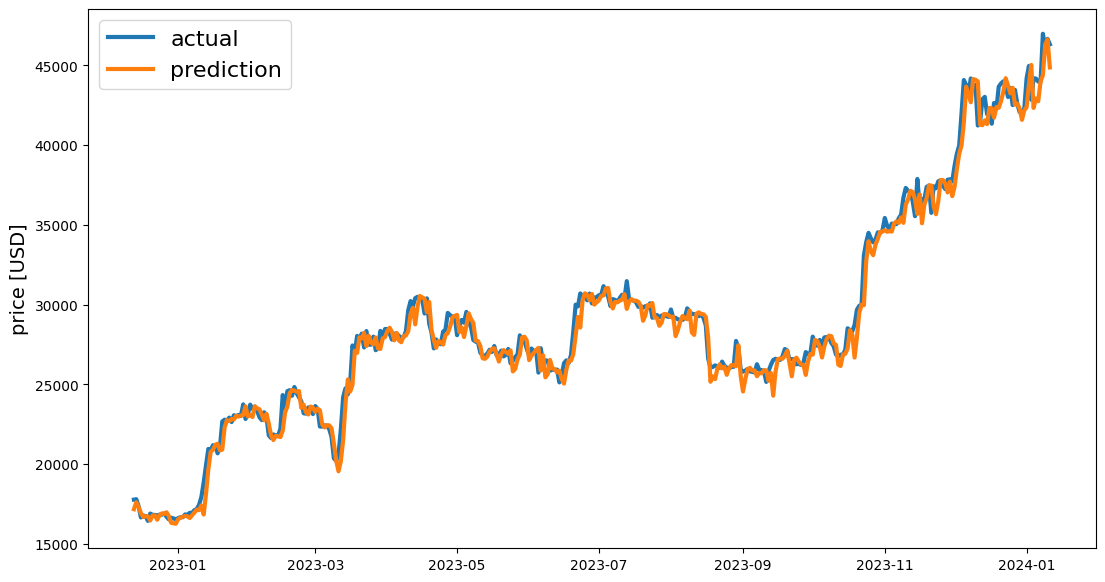

In [42]:
# Tracé comparatif des valeurs réelles et des prédictions faites par le modèle pour évaluer visuellement la précision des prédictions.
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)